In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os 
from xgboost import XGBClassifier
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import re
import sys 
import warnings
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

%matplotlib inline

In [2]:
home = os.getcwd() + '/'
with open(home+'sentiment_data/train.tsv') as f:
    df_raw = pd.read_csv(f, sep='\t')
df_raw.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [3]:
print('Number of rows: ', df_raw.shape[0])
print('Number of columns: ', df_raw.shape[1])
print('Column Names are',df_raw.columns.tolist())

Number of rows:  156060
Number of columns:  4
Column Names are ['PhraseId', 'SentenceId', 'Phrase', 'Sentiment']


In [4]:
df_raw.isnull().values.any()

False

2    79582
3    32927
1    27273
4     9206
0     7072
Name: Sentiment, dtype: int64


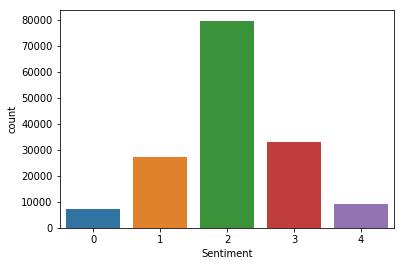

In [5]:
print(df_raw['Sentiment'].value_counts())
sns.countplot(x='Sentiment',data=df_raw)

We only need the phrases and their associated sentiments for our task, so we can safely drop the columns that only give some sort of identification

In [6]:
cols = df_raw.columns.tolist()
cols = cols[-2:] 
print(cols)
df = df_raw[cols]
df.head()

['Phrase', 'Sentiment']


,Phrase,Sentiment
0,A series of escapades demonstrating the adage ...,1
1,A series of escapades demonstrating the adage ...,2
2,A series,2
3,A,2
4,series,2


# WordCloud for Data Visualization

Let's see what the most prominent words are for our raw data frame

In [7]:
def draw_clouds(df):
    fig = plt.figure(figsize=(20, 20))
    columns, rows = 2, 3

    for sentiment in range(0,5): # sentiment value ranges from 0 to 4
        subset = df[df['Sentiment']==sentiment]
        text = subset['Phrase'].values
        cloud = WordCloud(
                                  stopwords=STOPWORDS,
                                  background_color='black',
                                  collocations=False,
                                  width=2500,
                                  height=1800
                                 ).generate(" ".join(text))

        fig.add_subplot(rows, columns, sentiment+1)
        plt.axis('off')
        plt.title("Rating %d" % sentiment,fontsize=40)
        plt.imshow(cloud)

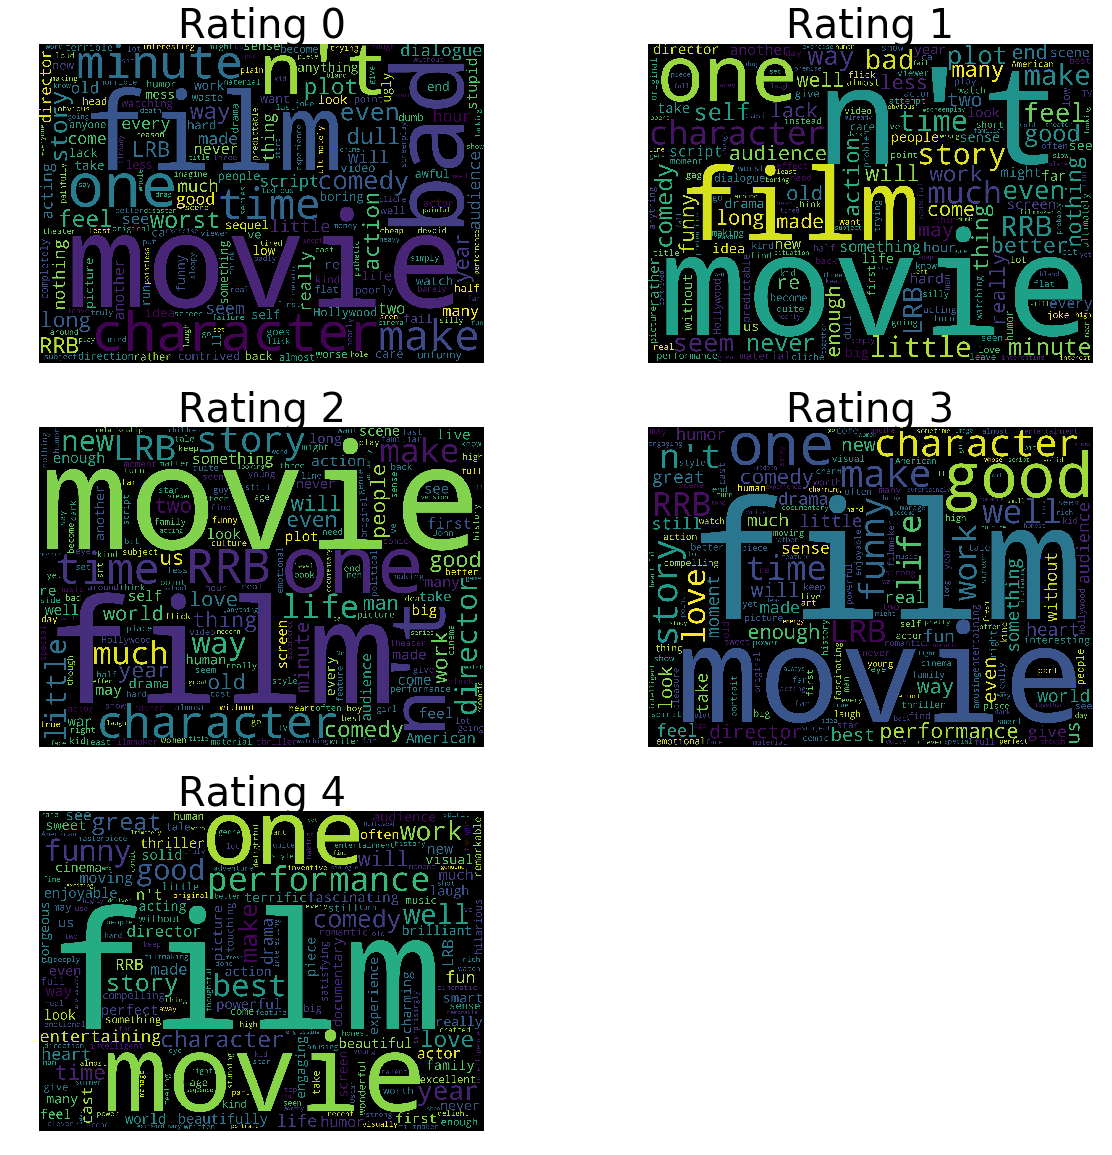

In [8]:
draw_clouds(df)

# Data Preprocessing

First, convert the text to lower-case and then use helper functions to remove punctuation and non-alphabetic characters

In [9]:
if not sys.warnoptions:
    warnings.simplefilter('ignore')
    
def cleanPunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n"," ")
    return cleaned

def keepAlpha(sentence):
    alpha_sent = ""
    for word in sentence.split():
        alpha_word = re.sub('[^a-z A-Z]+', ' ', word)
        alpha_sent += alpha_word
        alpha_sent += " "
    alpha_sent = alpha_sent.strip()
    return alpha_sent

In [10]:
df['Phrase'] = df['Phrase'].str.lower()
df['Phrase'] = df['Phrase'].apply(cleanPunc)
df['Phrase'] = df['Phrase'].apply(keepAlpha)

In [11]:
df.head()

,Phrase,Sentiment
0,a series of escapades demonstrating the adage ...,1
1,a series of escapades demonstrating the adage ...,2
2,a series,2
3,a,2
4,series,2


### Remove Stop Words
Next, we remove all stop-words present in the text by using the default set of stop-words from the NLTK library

In [12]:
stop_words = set(stopwords.words('english'))
re_stop_words = re.compile(r"\b(" + "|".join(stop_words) + ")\\W", re.I)

def removeStopWords(sentence):
    global re_stop_words
    return re_stop_words.sub("", sentence)

df['Phrase'] = df['Phrase'].apply(removeStopWords)

In [13]:
df.head()

,Phrase,Sentiment
0,series escapades demonstrating adage good goos...,1
1,series escapades demonstrating adage good goose,2
2,series,2
3,a,2
4,series,2


### Stemming
Next, perform stemming on the set of phrases

In [14]:
stemmer = SnowballStemmer('english')

def stemming(sentence):
    stem_sentence = ''
    for word in sentence.split():
        stem = stemmer.stem(word)
        stem_sentence += stem
        stem_sentence += ''
    stem_sentence = stem_sentence.strip()
    return stem_sentence

df['Phrase'] = df['Phrase'].apply(stemming)

### Word Clouds for Preprocessed Text
Now that we have done some preprocessing for our text, let's see the most prominent words in our dataframe

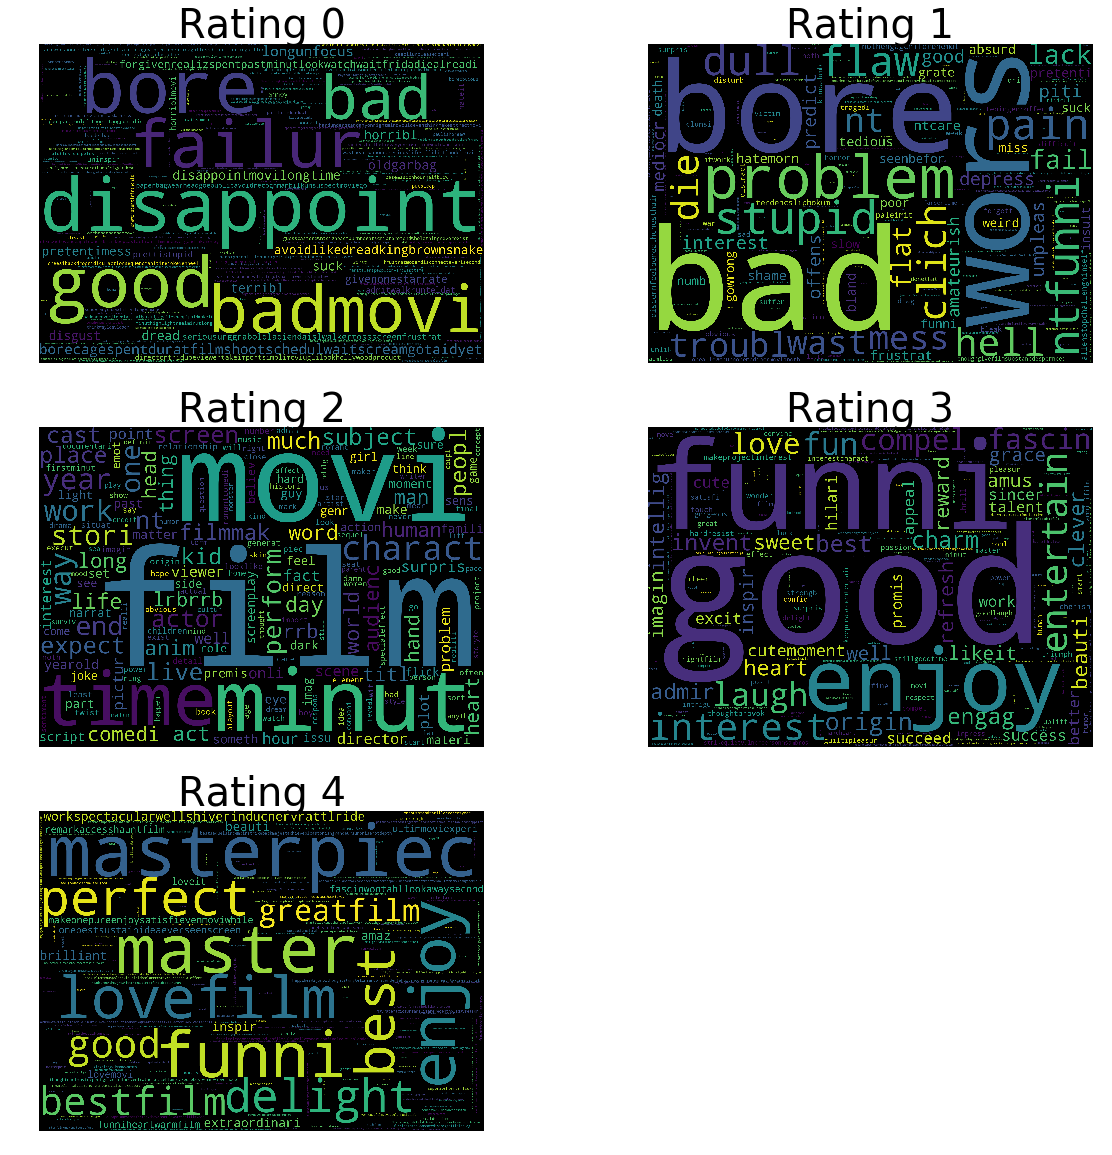

In [15]:
draw_clouds(df)

### TF-IDF
After creating our train and test sets, we need to summarize our text and convert them to numerical vectors. We need a measure of the uniqueness of a given word. We can use the TF-IDF of a word which gives a product of how frequent a word in in the document and how unique the word is with respect to the entire dataframe.

In [16]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, random_state=42, test_size=0.2, shuffle=True)
print(train.shape)
print(test.shape)

(124848, 2)
(31212, 2)


In [17]:
train_text = train['Phrase']
test_text = test['Phrase']

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,3), norm='l2')
vectorizer.fit(train_text)
vectorizer.fit(test_text)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents='unicode', sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [19]:
X_train = vectorizer.transform(train_text)
y_train = train.drop('Phrase', axis=1) # the last columns contains our target values

X_test = vectorizer.transform(test_text)
y_test = test.drop('Phrase', axis=1)

# Model Inference with XGBoost

In [33]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
predictions = xgb.predict(X_test)

In [35]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.50      0.00      0.01      1416
           1       0.86      0.00      0.00      5527
           2       0.50      1.00      0.67     15639
           3       0.64      0.00      0.00      6707
           4       0.64      0.00      0.01      1923

   micro avg       0.50      0.50      0.50     31212
   macro avg       0.63      0.20      0.14     31212
weighted avg       0.60      0.50      0.34     31212



In [29]:
test_data = pd.read_csv(os.getcwd()+'/sentiment_data/train.tsv', sep='\t')
test_data.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
